# 导入相关包

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import requests
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# 显示设置

In [2]:
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取数据

In [49]:
data=pd.read_csv('data_Italy.csv')
data2=pd.read_csv('data_Italy2.csv')

In [78]:
y_data = data2["total"]
x=data2["time1"]
global first_date # 后续数据可视化需要
x_data = np.asarray(range(0,len(y_data))) #时间用天数来进行表示

## 定义参数

In [ ]:
hyperparameters_r = None
hyperparameters_K = None

## 定义模型函数

In [ ]:
def logistic_increase_function(t,P0):
    # logistic生长函数：t:time   P0:initial_value    K:capacity  r:increase_rate
    # 后面将对r和K进行网格优化
    r = hyperparameters_r
    K = hyperparameters_K
    exp_value = np.exp(r * (t))
    return (K * exp_value * P0) / (K + (exp_value - 1) * P0)

## 定义参数优化函数

In [89]:
def fitting(logistic_increase_function, x_data, y_data):
    # 传入要拟合的logistic函数以及数据集
    # 返回拟合结果
    popt = None
    mse = float("inf")
    i = 0
    # 网格搜索来优化r和K参数
    r = None
    k = None
    k_range = np.arange(200000, 300000, 100)  ##设定取值范围
    r_range = np.arange(0, 1, 0.01)    
    for k_ in k_range:
        global hyperparameters_K
        hyperparameters_K = k_
        for r_ in r_range:
            global hyperparameters_r
            hyperparameters_r = r_
            # 用非线性最小二乘法拟合
            popt_, pcov_ = curve_fit(logistic_increase_function, x_data, y_data, maxfev = 4000)
            # 采用均方误准则选择最优参数
            mse_ = mean_squared_error(y_data, logistic_increase_function(x_data, *popt_))
            if mse_ <= mse:
                mse = mse_
                popt = popt_
                r = r_
                k = k_
            i = i+1
            print('\r当前进度：{0}{1}%'.format('▉'*int(i*10/len(k_range)/len(r_range)),int(i*100/len(k_range)/len(r_range))), end='')
    print('拟合完成')
    hyperparameters_K = k
    hyperparameters_r = r
    popt, pcov = curve_fit(logistic_increase_function, x_data, y_data)
    print("K:capacity  P0:initial_value   r:increase_rate")
    print(hyperparameters_K, popt, hyperparameters_r)
    return hyperparameters_K, hyperparameters_r, popt

## 定义预测函数

In [108]:
def predict(logistic_increase_function, popt):
    # 根据最优参数进行预测
    future = np.linspace(0, 112, 112)
    future = np.array(future)
    future_predict = logistic_increase_function(future, popt)
    diff = np.diff(future_predict)
    diff = np.insert(diff, 0, np.nan)
    return future, future_predict, diff

# 调用主函数

In [93]:
if __name__ == '__main__':
    # 拟合并通过网格调参寻找最优参数
    K, r, popt = fitting(logistic_increase_function, x_data, y_data)
    # 模型预测
    future, future_predict, diff= predict(logistic_increase_function, popt)

当前进度：▉▉▉▉▉▉▉▉▉▉100%拟合完成
K:capacity  P0:initial_value   r:increase_rate
230100 [4053.89063543] 0.09


## 将实际值与预测值作为纵轴，天数作为横轴来绘图，绘制出来图如下：

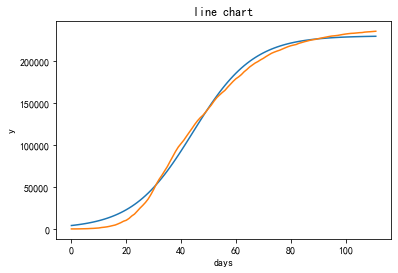

In [111]:
x = x_data
y1, y2 = future_predict,y_data
plt.plot(x, y1)
plt.plot(x, y2)
plt.title('line chart')
plt.xlabel('days')
plt.ylabel('y')
plt.show()